In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [41]:
feats_test = pd.read_csv(r'C:\Users\One\Git\coursera_introduction\week7\features_test.csv', index_col='match_id')
feats_train = pd.read_csv(r'C:\Users\One\Git\coursera_introduction\week7\features.csv', index_col='match_id')

# Подход 1: градиентный бустинг "в лоб"

1. Какие признаки имеют пропуски среди своих значений (приведите полный список имен этих признаков)? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?

In [25]:
missed_cols = feats_train.count() < len(feats_train)
missed_cols[missed_cols == True]

first_blood_time               True
first_blood_team               True
first_blood_player1            True
first_blood_player2            True
radiant_bottle_time            True
radiant_courier_time           True
radiant_flying_courier_time    True
radiant_first_ward_time        True
dire_bottle_time               True
dire_courier_time              True
dire_flying_courier_time       True
dire_first_ward_time           True
dtype: bool

Все признаки с first_blood% могут быть пустыми, т.к. это событие могло не произойти в первые 5 мин.

In [42]:
feats_train_dropped = feats_train.drop(["tower_status_radiant", "tower_status_dire",
                                        "barracks_status_radiant", "barracks_status_dire"], axis=1)

2. Как называется столбец, содержащий целевую переменную?

In [27]:
'radiant_win'

'radiant_win'

3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти выше по тексту. Какое качество при этом получилось?

In [43]:
from sklearn.metrics import roc_auc_score
feats_train_dropped.fillna(0, inplace=True)
feats_train_target = feats_train_dropped['radiant_win']
feats_train_dropped = feats_train_dropped.drop('radiant_win', axis = 1)

In [29]:
from sklearn.model_selection import train_test_split, KFold
X_train, X_valid, y_train, y_valid = train_test_split(feats_train_dropped, feats_train_target, 
                                                      test_size=0.3, 
                                                      random_state=17)


In [30]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
gbc = GradientBoostingClassifier()
gbc_pars = {'n_estimators': range(1, 31)}
gbc_grid = GridSearchCV(gbc, gbc_pars, cv=cv, scoring="roc_auc", n_jobs=-1)

In [31]:
%%time
gbc_grid.fit(X_train, y_train)
print(gbc_grid.best_params_)

{'n_estimators': 30}
Wall time: 6min 32s


In [9]:
%%time
gbc = GradientBoostingClassifier(n_estimators = gbc_grid.best_params_['n_estimators'])
gbc.fit(X_train, y_train)
y_pred = gbc.predict_proba(X_valid)[:, 1]
valid_score = roc_auc_score(y_valid, y_pred)
print('Validation ROC-AUC score:', valid_score)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что можно сделать, чтобы ускорить его обучение при увеличении количества деревьев?

Попробуем обучить классификатор на разном количестве деревьев для ответа на этот вопрос:

0.7286383729459075
0.6663184390336747
Wall time: 33min 53s


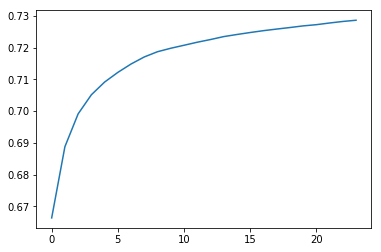

In [46]:
%%time


from tqdm import tqdm_notebook
valid_scores_lst = {}
for n in tqdm_notebook(range(10, 250, 10)):
    gbc = GradientBoostingClassifier(n_estimators=n, random_state=18)
    valid_scores_lst[n] = cross_val_score(gbc, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(valid_scores_lst.values())
print(max(valid_scores_lst.values()))
print(min(valid_scores_lst.values()))

Выигрыш при использовании количества деревьев больше 30 незначителен, а время обучения существенно вырастает. Смысл может быть в использовании в соревновании, или продакте, в наших задачах вряд ли.
Время обучения можно сократить выбросив неинформативные признаки, пропущенные значения, можно уменьшить глубину деревьев.

# Подход 2: логистическая регрессия

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем можно объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?


{-5: 0.5134470485654341, -4: 0.5134470485654341, -3: 0.5134470485654341, -2: 0.5134470485654341, -1: 0.5134470485654341, 0: 0.5134470485654341, 1: 0.5134470485654341, 2: 0.5134470485654341, 3: 0.5134470485654341, 4: 0.5134470485654341, 5: 0.5134470485654341, 6: 0.5134470485654341, 7: 0.5134470485654341, 8: 0.5134470485654341, 9: 0.5134470485654341}
Wall time: 14 s


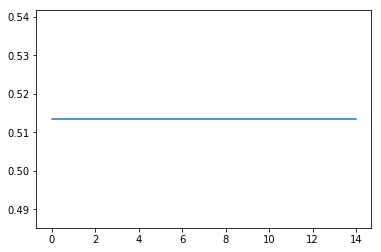

In [32]:
%%time
from tqdm import tqdm_notebook
valid_scores_dct_lr = {}
for n in tqdm_notebook(np.arange(-5, 10)):
    lr = LogisticRegression(C = np.power(10.0, n))
    valid_scores_dct_lr[n] = cross_val_score(lr, X_train, y_train, cv=cv,
                                             scoring="roc_auc", n_jobs=-1).mean()  
print(valid_scores_dct_lr)
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(valid_scores_dct_lr.values())

Логистическая регрессия значительно проигрывает градиентному бустингу, т.к. она лучше работает с числовыми признаками, а в данном датасете немало категориальных, которые логит воспринимает как количественную хар-ку  параметра объекта.

In [33]:
feats_train_dropped = feats_train_dropped.drop(['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 
                  'd3_hero', 'd4_hero', 'd5_hero'], axis = 1)

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(feats_train_dropped, feats_train_target, test_size=0.3, random_state=17)

2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем можно объяснить это изменение?


{-5: 0.5134470485654341, -4: 0.5134470485654341, -3: 0.5134470485654341, -2: 0.5134470485654341, -1: 0.5134470485654341, 0: 0.5134470485654341, 1: 0.5134470485654341, 2: 0.5134470485654341, 3: 0.5134470485654341, 4: 0.5134470485654341, 5: 0.5134470485654341, 6: 0.5134470485654341, 7: 0.5134470485654341, 8: 0.5134470485654341, 9: 0.5134470485654341}
Wall time: 10.6 s


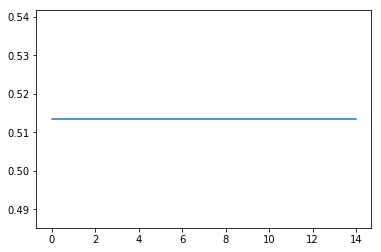

In [37]:
%%time
from tqdm import tqdm_notebook
valid_scores_dct_lr = {}
for n in tqdm_notebook(np.arange(-5, 10)):
    lr = LogisticRegression(C = np.power(10.0, n))
    valid_scores_dct_lr[n] = cross_val_score(lr, X_train, y_train, cv=cv,
                                             scoring="roc_auc", n_jobs=-1).mean()  
print(valid_scores_dct_lr)
from matplotlib import pyplot as plt
plt.plot(valid_scores_dct_lr.values())

3. Сколько различных идентификаторов героев существует в данной игре?

In [63]:
feats_train = pd.read_csv(r'C:\Users\One\Git\coursera_introduction\week7\features.csv', index_col='match_id')

feats_train_target = feats_train['radiant_win']

In [44]:
for her in ['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 
                  'd3_hero', 'd4_hero', 'd5_hero']:
    print(feats_train_dropped[her].value_counts().shape)

(108,)
(108,)
(108,)
(108,)
(108,)
(108,)
(108,)
(108,)
(108,)
(108,)


108, eсли удалить строки с пропущенными значениями - 107

4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем можно это объяснить?

In [45]:
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import hstack
enc = DictVectorizer()
feats_train_2 = enc.fit_transform(feats_train_dropped[['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 
                  'd3_hero', 'd4_hero', 'd5_hero']].to_dict('records'))

In [46]:
X_for_train = hstack([feats_train, feats_train_2])

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(X_for_train, feats_train_target, 
                                                      test_size=0.1, 
                                                      random_state=17)

In [48]:
%%time
from tqdm import tqdm_notebook
lr = LogisticRegression(solver = 'liblinear', C = 1)
print((cross_val_score(lr, X_train, y_train, cv=5)).mean())   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Качество не улучшилось, предыдущее было 0.5273700609571209

5. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?

максимальное - 0.9990273330536076, 
минимальное - 0.9904623250309014